In [44]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')  
%matplotlib inline

# Create our portfolio of equities
tickers = ['AAPL','FB', 'C', 'DIS']

# Download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())['Close']

# From the closing prices, calculate periodic returns
returns = data.pct_change()

# Preview the data
data.tail()

Symbols,AAPL,FB,C,DIS
Date,,,,
2022-10-24,149.449997,129.720001,44.410000,101.720001
2022-10-25,152.339996,137.509995,45.320000,104.360001
2022-10-26,149.350006,129.820007,45.410000,104.629997
2022-10-27,144.800003,97.940002,45.439999,104.440002
2022-10-28,155.740005,99.199997,46.130001,105.949997


Text(0, 0.5, 'price ($)')

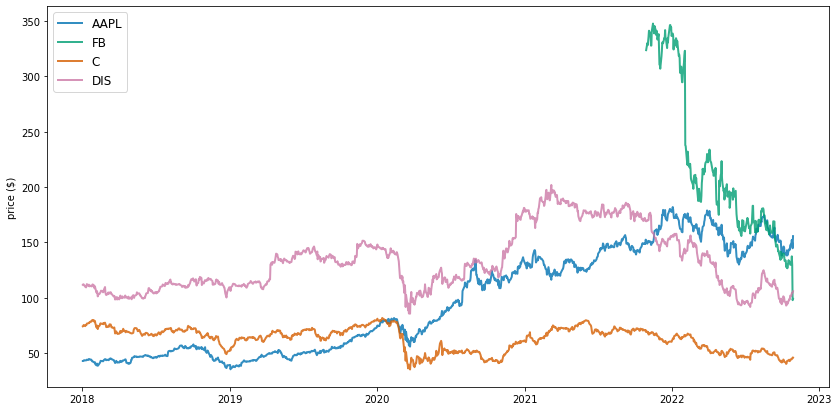

In [45]:
plt.figure(figsize=(14, 7))
for i in data.columns.values:
    plt.plot(data.index, data[i], lw=2, alpha=0.8,label=i)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price ($)')

Text(0, 0.5, 'daily returns')

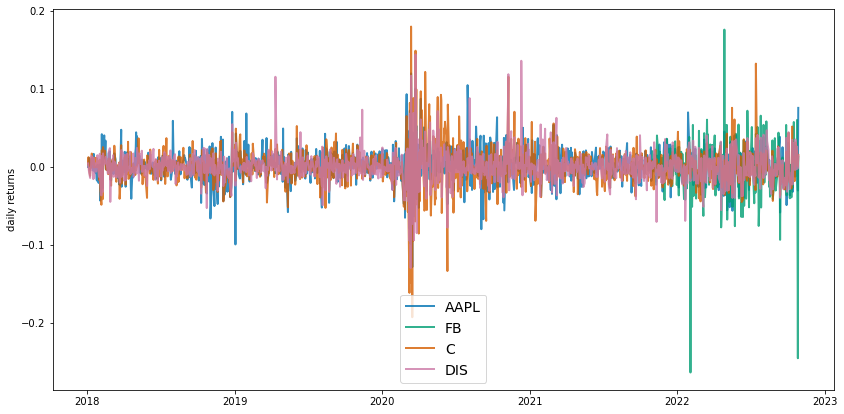

In [46]:
returns = data.pct_change()

plt.figure(figsize=(14, 7))
for i in returns.columns.values:
    plt.plot(returns.index, returns[i], lw=2, alpha=0.8,label=i)
plt.legend(loc='lower center', fontsize=14)
plt.ylabel('daily returns')

In [47]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) *252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [48]:
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 equities
        weights = np.random.random(4)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

In [49]:
def display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):

    # pull results, weights from random portfolios
    results, weights = generate_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    print("-"*100)
    print("Portfolio at maximum Sharpe Ratio\n")
    print("--Returns, volatility--\n")
    print("Annualized Return:", round(returns_portfolio,2))
    print("Annualized Volatility:", round(stdev_portfolio,2))

    print("\n")
    print("--Allocation at max Sharpe ratio--\n")
    print(max_sharpe_allocation)
    print("-"*100)

    plt.figure(figsize=(16, 9))
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    # Mark the portfolio w/ max Sharpe ratio
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)

----------------------------------------------------------------------------------------------------
Portfolio at maximum Sharpe Ratio

--Returns, volatility--

Annualized Return: 0.28
Annualized Volatility: 0.32


--Allocation at max Sharpe ratio--

Symbols      AAPL    FB     C   DIS
allocation  88.87  0.33  7.51  3.29
----------------------------------------------------------------------------------------------------


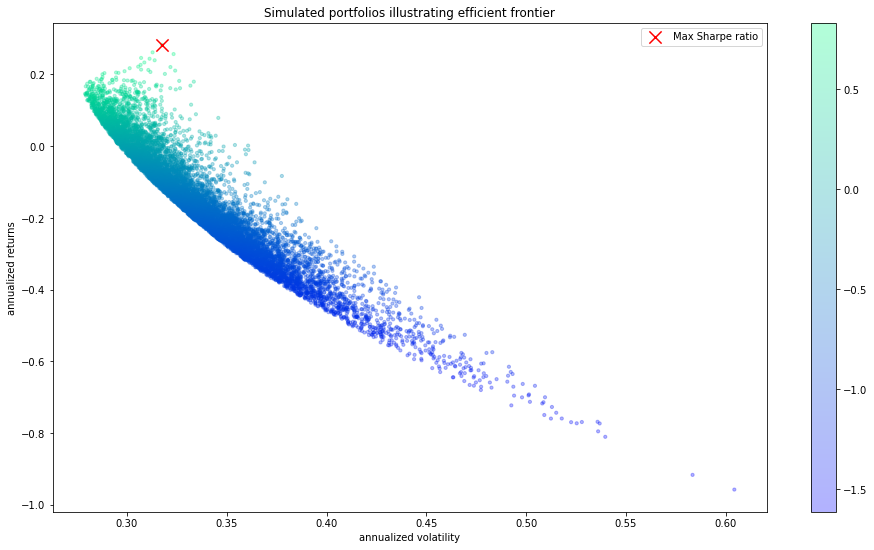

In [50]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
# Number of portfolios to simulate
num_portfolios = 10000
# Risk free rate (used for Sharpe ratio below)
# anchored on treasury bond rates
risk_free_rate = 0.018
display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate)